In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor, RandomForestClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor

## 1) Bagging
Para esse exercício, precisaremos de novos dados, dessa vez das eleições municípais de 2000. A base que usaremos indica qual partido venceu, se PMDB/PSDB/PFL ou outros, e variáveis econômicas e demográficas (não se esqueça de remover IDs e nome dos municípios, como cod_mun_ibge e nome_municipio; se usar Python, também não se esqueça de transformar/remover as variáveis uf e coligacao):

In [2]:
link = 'https://raw.githubusercontent.com/FLS-6497/datasets/main/aula7/eleicoes2000.csv'
dados = pd.read_csv(link, sep=';', decimal=",").drop(['cod_mun_ibge', 'nome_municipio'], axis=1)

### a) Exploração
Explore rapidamente a base de dados. Para tanto, você pode criar gráficos com as distribuições do target e de algumas features, com cruzamentos das variáveis ou, ainda, usar correlações. Quais variáveis parecem ter mais relação com o target partido?

In [3]:
dados[['outros_partidos', 'pmdb_psdb_pfl']] = pd.get_dummies(dados.partido)

<AxesSubplot:>

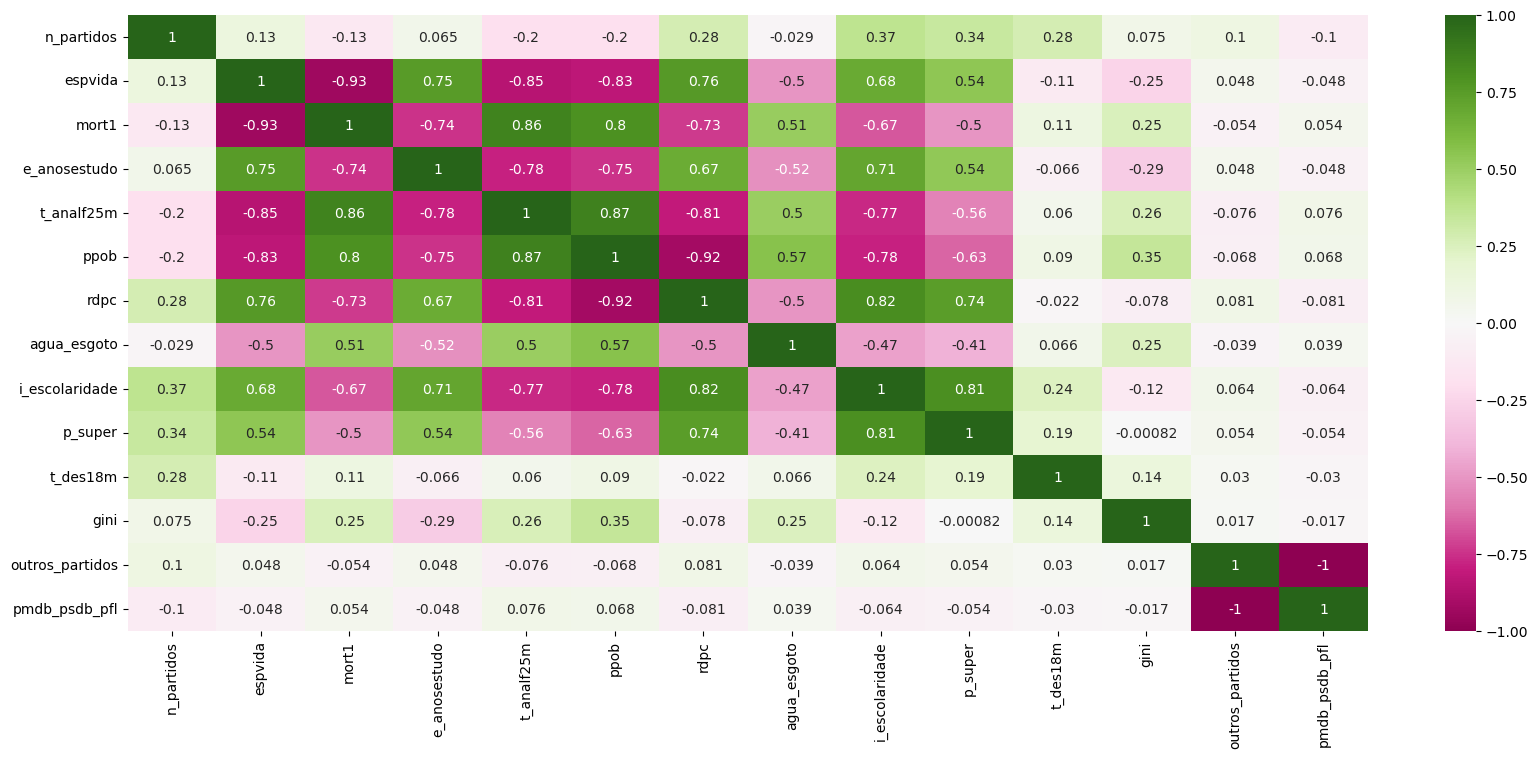

In [4]:
plt.rcParams['figure.figsize'] = [20, 8]
(
    sns.heatmap(
        dados.corr(), 
        annot=True, 
        annot_kws={"fontsize":10}, 
        cmap="PiYG"
        )
    )
# correlações muito baixas - rdpc, t_analf25m, ppob, i_escolaridade,mort1, p_super - em ordem 

In [5]:
dados_dummies = (
    pd.concat([
        dados, 
        pd.get_dummies(dados.uf)
        ], 
        axis=1
        )
    )
dados_dummies = dados_dummies.drop(['uf', 'coligacao', 'partido', 'outros_partidos'], axis=1)

### b) Criação de pipelines com bagging
Usando pipelines, crie um bagging ensemble combinando quantos e quais modelos você quiser e outra pipeline usando Naive Bayes. Treine e compare os resultados destas pipelines.

In [6]:
y = dados_dummies.pmdb_psdb_pfl
X = dados_dummies.loc[:, dados_dummies.columns != 'pmdb_psdb_pfl']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

gnb = GaussianNB().fit(X_train, y_train)

bag = (
    BaggingRegressor(
        base_estimator=GaussianNB(), 
        n_estimators=10
        )
        .fit(X_train, y_train)
        )

y_pred_gnb = gnb.predict(X_test)
print(mean_squared_error(y_test, y_pred_gnb, squared=False))

y_pred_bag = bag.predict(X_test)
print(mean_squared_error(y_test, y_pred_bag, squared=False))

0.6275977285243859
0.5579224364638694


### c) Variações
Agora, crie outros dois bagging ensembles, um deles fazendo subsample dos dados (no mlr3, isso é controlado pelo argumento frac no po com subsample) e, o outro, utilizando um modelo diferente do que você utilizou na bagg anterior. Treine e compare os resultados destas novas pipelines.

In [7]:
bag_subsample = (
    BaggingRegressor(
        base_estimator=GaussianNB(), 
        n_estimators=10,
        max_samples=0.33
        )
        .fit(X_train, y_train)
        )

y_pred_bag_subsample = bag_subsample.predict(X_test)
print(mean_squared_error(y_test, y_pred_bag_subsample, squared=False))

0.5512219535261952


In [8]:
bag_ols = (
    BaggingRegressor(
        base_estimator=LinearRegression(), 
        n_estimators=10
        )
        .fit(X_train, y_train)
        )

y_pred_bag_ols = bag_ols.predict(X_test)
print(mean_squared_error(y_test, y_pred_bag_ols, squared=False))

0.47761109409187985


In [9]:
bag_subsample_ols = (
    BaggingRegressor(
        base_estimator=LinearRegression(), 
        n_estimators=10,
        max_samples=0.33
        )
        .fit(X_train, y_train)
        )

y_pred_bag_subsample_ols = bag_subsample_ols.predict(X_test)
print(mean_squared_error(y_test, y_pred_bag_subsample_ols, squared=False))

0.47934287120322683


### d) Random forest
Crie uma pipeline agora usando random forest (fique à vontade para customizar ela como achar melhor) e compare seus resultados com o da melhor pipeline que você encontrou no exercício anterior.

In [10]:
rfc = RandomForestClassifier().fit(X_train, y_train)

bag_rfc = (
    BaggingRegressor(
        base_estimator=RandomForestClassifier(), 
        n_estimators=10,
        max_samples=0.33
        )
        .fit(X_train, y_train)
        )

y_pred_rfc = rfc.predict(X_test)
print(mean_squared_error(y_test, y_pred_rfc, squared=False))

y_pred_bag_rfc = bag_rfc.predict(X_test)
print(mean_squared_error(y_test, y_pred_bag_rfc, squared=False))

0.616365843441008
0.5372609867939464


## 2) Stacking
### a) Básico
Adaptando o exemplo dos materiais de aula, crie uma pipeline que use stacking para combinar os resultados de três modelos diferentes. Os modelos de nível 0 podem ter tanto etapas de pré-processamento, modelos ou parâmetros diferentes (e.g., é possível treinar 3 árvores diferentes). Como blender, use um modelo de regressão logística simples (no mlr3, classif.log_ref; no sklearn, LogisticRegression). Treine e veja os resultados desta pipeline.

In [11]:
# Treina os modelos
modelos = [('knn', KNeighborsClassifier()),
           ('dt', DecisionTreeClassifier()),
           ('rf', RandomForestClassifier(n_estimators=50))
          ]

stack = StackingClassifier(estimators=modelos, final_estimator=LogisticRegression())\
    .fit(X_train, y_train)

# Calcula metricas
pred = stack.predict(X_test)
mean_squared_error(y_test, pred, squared=False)

0.6169053322475195

### b) Ensemble em cima de ensemble
Ao stack anterior, adapte e adicione agora o melhor bagging ensemble que você encontrou no exercício 1. Treine e veja o resultado dessa nova versão.

In [12]:
# bag_ols = (
#     BaggingRegressor(
#         base_estimator=LinearRegression(), 
#         n_estimators=10
#         )
#         .fit(X_train, y_train)
#         )

# modelos = [('knn', KNeighborsClassifier()),
#            ('dt', DecisionTreeClassifier()),
#            ('rf', RandomForestClassifier(n_estimators=50)),
#            ('bag', bag_ols())
#           ]

# stack = StackingClassifier(estimators=modelos, final_estimator=LogisticRegression())\
#     .fit(X_train, y_train)

# # Calcula metricas
# pred = stack.predict(X_test)
# mean_squared_error(y_test, pred, squared=False)

## 3) Boosting
Para quem usa R, neste exercício será necessário converter features categóricas para numeric (o XGboost só aceita variáveis numéricas). Podemos criar uma nova base assim com o seguinte código:

### a) Gradiente
Treine dois ensembles com boosting, um usando gradient boosting e, o outro, extreme gradient boosting. Compare os resultados.

In [13]:


# Treina os modelos
gb = GradientBoostingRegressor(n_estimators=50)\
    .fit(X_train, y_train)

xgb = XGBRegressor(n_estimators=50)\
    .fit(X_train, y_train)

# Calcula metricas
pred_gb = gb.predict(X_test)
print(mean_squared_error(y_test, pred_gb, squared=False))

pred_xgb = xgb.predict(X_test)
print(mean_squared_error(y_test, pred_xgb, squared=False))

0.4798427298530994
0.512426


### b) Número de árvores em boosting
Usando extreme boosting, crie três pipelines: uma que treine 10 modelos, outra que treine 100 e, por fim, uma que treine 200. O que acontece com os resultados?

In [14]:
def get_xgb_mse():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    xgb = XGBRegressor(n_estimators=50)\
        .fit(X_train, y_train)
    pred_xgb = xgb.predict(X_test)
    return mean_squared_error(y_test, pred_xgb, squared=False)

xgb_10 = [get_xgb_mse() for i in range(10)]
xgb_100 = [get_xgb_mse() for i in range(100)]
xgb_200 = [get_xgb_mse() for i in range(200)]

<AxesSubplot:ylabel='Count'>

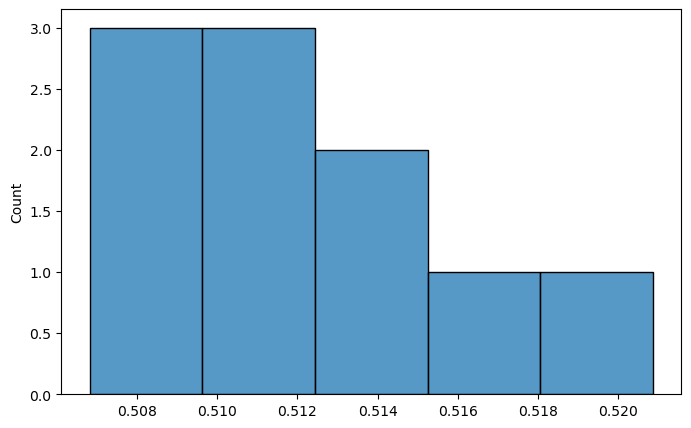

In [15]:
plt.rcParams['figure.figsize'] = [8, 5]
sns.histplot(xgb_10)

<AxesSubplot:ylabel='Count'>

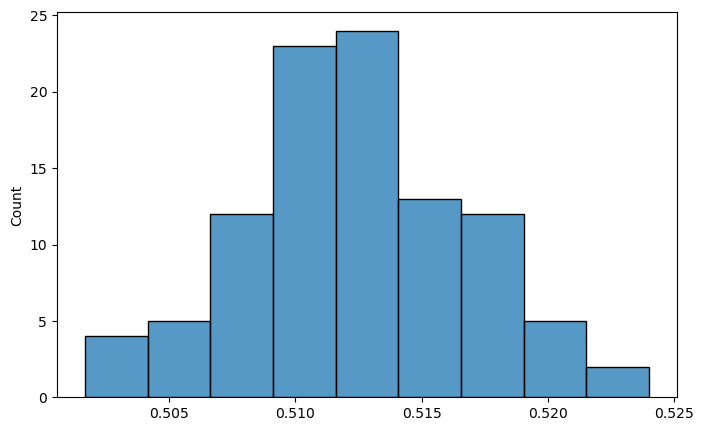

In [16]:
sns.histplot(xgb_100)

<AxesSubplot:ylabel='Count'>

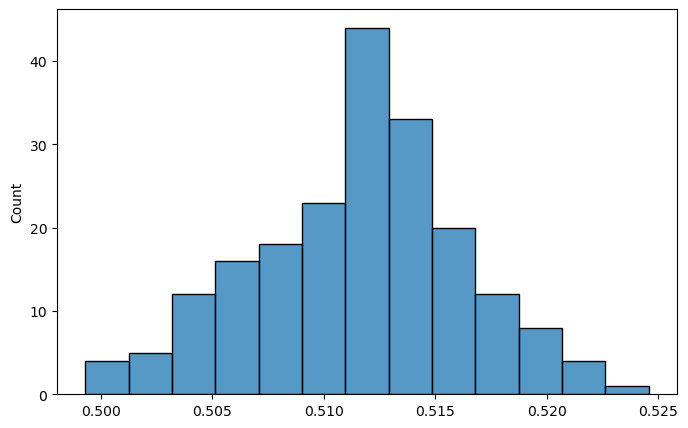

In [17]:
sns.histplot(xgb_200)

## 4) Validação
Usando o melhor ensemble que você encontrou nessa aula, o valide usando estes dados das eleições de 2004 – que foram um pouco diferentes das de 2000 em termos de desempenho dos partidos (lembre-se de que é preciso treinar do zero o melhor modelo nos dados completos de 2000 antes de fazer a validação).2.

In [18]:
link = 'https://raw.githubusercontent.com/FLS-6497/datasets/main/aula7/eleicoes2004.csv'
dados = pd.read_csv(link, sep=';', decimal=",").drop(['cod_mun_ibge', 'nome_municipio'], axis=1)

In [19]:
dados[['outros_partidos', 'pmdb_psdb_pfl']] = pd.get_dummies(dados.partido)

dados_dummies = (
    pd.concat([
        dados, 
        pd.get_dummies(dados.uf)
        ], 
        axis=1
        )
    )
dados_dummies = dados_dummies.drop(['uf', 'coligacao', 'partido', 'outros_partidos'], axis=1)

y = dados_dummies.pmdb_psdb_pfl
X = dados_dummies.loc[:, dados_dummies.columns != 'pmdb_psdb_pfl']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

gb = GradientBoostingRegressor(n_estimators=50).fit(X_train, y_train)

pred_gb = gb.predict(X_test)
print(mean_squared_error(y_test, pred_gb, squared=False))

0.49525321241999615
